# Evaluation on Validation Set

### Preparation of Multi-view Images for Display

In [2]:
from PIL import Image

def combine_images(image_paths):
    # Open images
    images = [Image.open(path) for path in image_paths]

    # Get dimensions of the first image
    width, height = images[0].size

    # Create a new image with the combined size
    combined_image = Image.new("RGB", (width * 3, height * 2))

    # Paste each image into the combined image
    for i in range(6):
        x = (i % 3) * width
        y = (i % 2) * height
        combined_image.paste(images[i], (x, y))

    combined_image = combined_image.resize((1200, 450))
    return combined_image

def get_multiview_image_paths(dataset, sample_token):
    sample = dataset.get("sample", sample_token)
    return [
        dataset.get_sample_data(sample["data"]["CAM_FRONT_LEFT"])[0],
        dataset.get_sample_data(sample["data"]["CAM_BACK"])[0],
        dataset.get_sample_data(sample["data"]["CAM_FRONT_RIGHT"])[0],
        dataset.get_sample_data(sample["data"]["CAM_BACK_RIGHT"])[0],
        dataset.get_sample_data(sample["data"]["CAM_FRONT"])[0],
        dataset.get_sample_data(sample["data"]["CAM_BACK_LEFT"])[0],
    ]


### Evaluation of a Single Sample

In [3]:
import os
import torch
from eval_blip_bev import LanguageEvaluation, GPTEvaluation

def evaluate_single(model, dataset, statements, sample_token):
    
    sample = dataset.get("sample", sample_token)
    scene_token = sample["scene_token"]

    for statement in statements:
        if statement["scene_token"] == scene_token:
            gt = statement["statement"]
            desc = statement["scene_description"]
            break
    
    bev_filename = f"{sample_token}.pt"
    with open(os.path.join("/workspace/BLIP/data_thesis/bev_features/tiny/val/", bev_filename), "rb") as bev_file:
        bev = torch.load(bev_file)

    pred  = model.generate(bev)[0]
    lang_scores = LanguageEvaluation.evaluate(pred, gt)
    gpt_score = GPTEvaluation.evaluate(pred, gt)

    return {"Description": desc, 
            "GT": gt, 
            "Prediction": pred, 
            "BLEU-4": lang_scores["Bleu_4"], 
            "METEOR": lang_scores["METEOR"], 
            "ROGUE-L": lang_scores["ROUGE_L"], 
            "CIDEr": lang_scores["CIDEr"],
            "SPICE": lang_scores["SPICE"],
            "GPT": gpt_score}

### Loading Scene Statemens

In [4]:
import json

with open("./data_thesis/scene_statements.json", "r") as scene_statements_json:
    scene_statements = json.load(scene_statements_json)

### Preparation of Plot with Multi-view Images and Evaluation Metrics Table

In [8]:
import matplotlib.pyplot as plt
import textwrap

def wrap_text(text, width):
    return '\n'.join(textwrap.wrap(text, width))

def show_results(model, dataset, statements, sample_tokens):

    num_samples = len(sample_tokens)

    images = [combine_images(get_multiview_image_paths(dataset, sample_token)) for sample_token in sample_tokens]
    values = [evaluate_single(model, dataset, statements, sample_token) for sample_token in sample_tokens];

    # Create figure and axes
    fig, axs = plt.subplots(num_samples*2, 1, figsize=(9, num_samples * 10))  # Adjusted for extra space for texts

    for i in range(num_samples):
        axs[i*2].imshow(images[i])
        axs[i*2].axis('off')
        axs[i*2].set_title(f"Sample {i+1} ({sample_tokens[i]})")

        wrapped_values = {k: wrap_text(str(v), width=110) for k, v in values[i].items()}

        row_labels = list(wrapped_values.keys())
        cell_text = [[v] for v in wrapped_values.values()]

        axs[i*2 + 1].axis('tight')
        axs[i*2 + 1].axis('off')
        table = axs[i*2 + 1].table(cellText=cell_text, rowLabels=row_labels, loc='center', bbox=[0.08, 0.05, 0.92, 1.1], colWidths=[1.2]*len(row_labels))
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1)

        # Aligning text in the table cells to the left
        for key, cell in table.get_celld().items():
            cell.set_text_props(ha='left')
            cell.PAD = 0.02  # Adjust padding if necessary

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.005)
    plt.show()


### Loading NuScenes Dataset

In [1]:
from nuscenes.nuscenes import NuScenes

nuscenes_dataset = NuScenes(version="v1.0-trainval", dataroot="/workspace/BLIP/data_thesis/nuscenes2/", verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 32.201 seconds.
Reverse indexing ...
Done reverse indexing in 10.1 seconds.


### Loading the BLIP-BEV Model

In [7]:
import os
import numpy as np
import random
import glob
import torch
import torch.backends.cudnn as cudnn
from models.blip_bev_pretrain import BLIP_BEV_Pretrain

torch.cuda.empty_cache()
device = torch.device("cuda")

# fix the seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

model = BLIP_BEV_Pretrain(queue_size=100);
model = model.to(device)
model.load_state_dict(torch.load("/workspace/BLIP/output/Pretrain_BEV/Ex5_bs5_qs100_lr_1e-5_vit3_10_768_7.pth")["model"])

/embeddings/word_embeddings is tied
/embeddings/position_embeddings is tied
/embeddings/LayerNorm is tied
/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
/encoder/layer/2/crossattention/self/query is tied
/encoder/layer/2/crossattention/self/key is tied
/encoder/layer/2/crossat

### Loading BEV Files List

In [ ]:
bev_files_list = glob.glob(os.path.join("/workspace/BLIP/data_thesis/bev_features/tiny/val/", "*.pt"))

### Displaying Evaluation Results for N Samples

[5238, 912, 204, 2253, 2006, 1828]
['69c041c7c3bd464386e64f0b4c72427b', '617899966d3e4fea9042a1f1a26b764e', '7e33c76cba554286bfdd8b02da989b8b', '60f5b50bd3a146c08d016cee80637f62', 'bc5bcc4d1ff549858613e15e46ffd76b', '3d827c0fa2a5480f91c019a5839ad07f']


PTBTokenizer tokenized 24 tokens at 664.15 tokens per second.
PTBTokenizer tokenized 24 tokens at 700.84 tokens per second.


{'testlen': 23, 'reflen': 22, 'guess': [23, 22, 21, 20], 'correct': [6, 2, 1, 0]}
ratio: 1.0454545454070248


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 4.557 s


PTBTokenizer tokenized 29 tokens at 844.26 tokens per second.
PTBTokenizer tokenized 26 tokens at 756.47 tokens per second.


{'testlen': 25, 'reflen': 26, 'guess': [25, 24, 23, 22], 'correct': [10, 6, 5, 4]}
ratio: 0.9615384615014793


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5 sec].
Loading classif

SPICE evaluation took: 6.356 s


PTBTokenizer tokenized 36 tokens at 1006.21 tokens per second.
PTBTokenizer tokenized 29 tokens at 812.79 tokens per second.


{'testlen': 25, 'reflen': 32, 'guess': [25, 24, 23, 22], 'correct': [10, 0, 0, 0]}
ratio: 0.781249999975586


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5 sec].
Loading classif

SPICE evaluation took: 6.491 s


PTBTokenizer tokenized 44 tokens at 1272.70 tokens per second.
PTBTokenizer tokenized 25 tokens at 718.63 tokens per second.


{'testlen': 22, 'reflen': 39, 'guess': [22, 21, 20, 19], 'correct': [15, 5, 3, 2]}
ratio: 0.5641025640881


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5 sec].
Loading classif

SPICE evaluation took: 6.532 s


PTBTokenizer tokenized 36 tokens at 1040.58 tokens per second.
PTBTokenizer tokenized 45 tokens at 1305.52 tokens per second.


{'testlen': 42, 'reflen': 32, 'guess': [42, 41, 40, 39], 'correct': [18, 2, 0, 0]}
ratio: 1.3124999999589846


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5 sec].
Loading classif

SPICE evaluation took: 6.699 s


PTBTokenizer tokenized 40 tokens at 1133.80 tokens per second.
PTBTokenizer tokenized 18 tokens at 523.55 tokens per second.


{'testlen': 16, 'reflen': 35, 'guess': [16, 15, 14, 13], 'correct': [9, 3, 1, 0]}
ratio: 0.45714285712979597


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.9 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5 sec].
Loading classif

SPICE evaluation took: 6.541 s


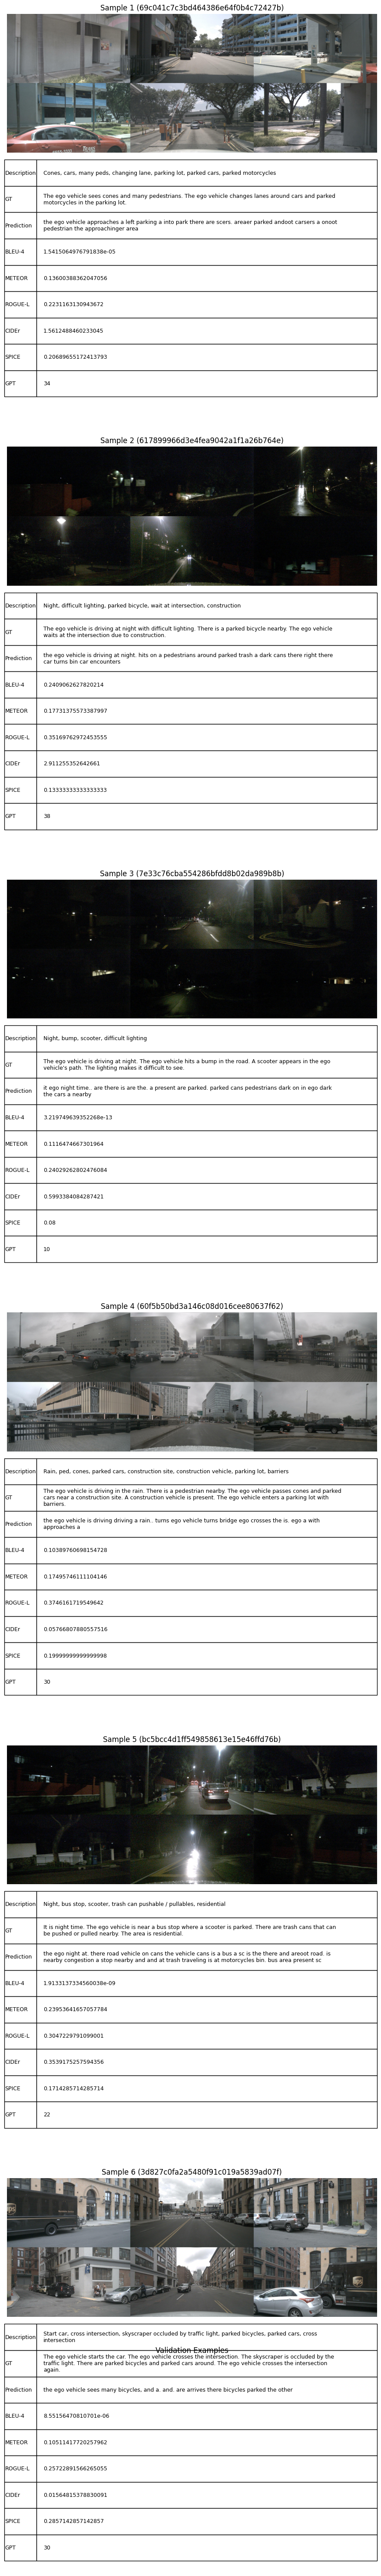

In [9]:
# Number of random samples to be evaluated
n = 6

random_indices = [random.randint(0, len(bev_files_list)-1) for _ in range(n)]
sample_tokens = [bev_files_list[i][bev_files_list[i].rfind("/")+1:-3] for i in random_indices]

show_results(model, nuscenes_dataset, scene_statements, sample_tokens)